In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from stable_baselines3.ppo import PPO

from utils.data_handling import get_episode_reward_data, get_sar_data
from utils.plot_functions import plot_learning_tr, plot_rewards, plot_actions, plot_k_array
from utils.multigrid_plot_functions import singlegrid_learning_plots, multigrid_learning_plots
from utils.env_wrappers import StateCoarse

import matplotlib
matplotlib.rcParams['text.usetex'] = True

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
case_label='case_1'
seed=3

ppo_dir_sg_quarter = '../ppo_multigrid/data/'+case_label+'_singlegrid_quarter'
ppo_dir_sg_half = '../ppo_multigrid/data/'+case_label+'_singlegrid_half'
ppo_dir_sg_one = '../ppo_multigrid/data/'+case_label+'_singlegrid_one'
ppo_dir_fixed_mg = '../ppo_multigrid/data/'+case_label+'_multigrid_fixed'
ppo_dir_ada_mg = '../ppo_multigrid/data/'+case_label+'_multigrid_adaptive'

data_dir = './'+case_label
opt_dir = '../de/'+case_label
os.makedirs(data_dir, exist_ok=True)

# learning plots

<IPython.core.display.Javascript object>


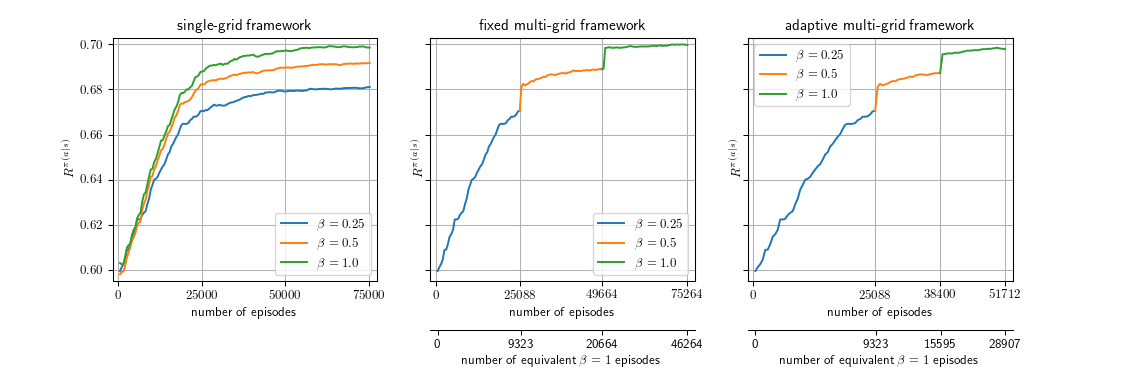

In [4]:
seed_array=[seed]
fidelity_indices_array_adaptive = [[0,48,74],[0,48,74],[0,48,74]]

for seed_ in seed_array:

    fig,ax = plt.subplots(1,3,figsize=(12,4), sharey=True)
    fig.subplots_adjust(top=0.9,
                        bottom=0.25,
                        left=0.1,
                        right=0.9)

    # plot singlegrid framework learning
    singlegrid_learning_plots( axis=ax[0],
                               log_dir_array=[ppo_dir_sg_quarter, ppo_dir_sg_half, ppo_dir_sg_one],
                               grid_fidelity_array=[0.25,0.5,1.0],
                               episode_limit_array=[25000,25000,25000],
                               seed_no=seed_,
                               result_type='train',
                               x_label='number of episodes',
                               y_label=r'$R^{\pi(a|s)}$',
                               title='single-grid framework')


    # plot multigrid fixed framework learning
    multigrid_learning_plots( axis=ax[1],
                              log_dir=ppo_dir_fixed_mg,
                              grid_fidelity_array=[0.25,0.5,1.0],
                              episode_limit_array=[25000,25000,25000],
                              equivalent_fine_runtime_array=[0.37,0.45,1],
                              fidelity_indices=[0,48,96],
                              seed_no=seed_,
                              result_type='train',
                              x_label='number of episodes',
                              y_label=r'$R^{\pi(a|s)}$',
                              x_label_2=r'number of equivalent $\beta=1$ episodes',
                              title='fixed multi-grid framework')

    # plot multigrid adaptive framework learning
    multigrid_learning_plots( axis=ax[2],
                              log_dir=ppo_dir_ada_mg,
                              grid_fidelity_array=[0.25,0.5,1.0],
                              episode_limit_array=[25000,25000,25000],
                              equivalent_fine_runtime_array=[0.37,0.45,1],
                              fidelity_indices=fidelity_indices_array_adaptive[seed_-1],
                              seed_no=seed_,
                              result_type='train',
                              x_label='number of episodes',
                              y_label=r'$R^{\pi(a|s)}$',
                              x_label_2=r'number of equivalent $\beta=1$ episodes',
                              title='adaptive multi-grid framework')

    fig.savefig(data_dir+'/'+case_label+'_seed_'+str(seed_)+'_rl_mg_plots.pdf')

# plot trainging log-permeabilities

<IPython.core.display.Javascript object>


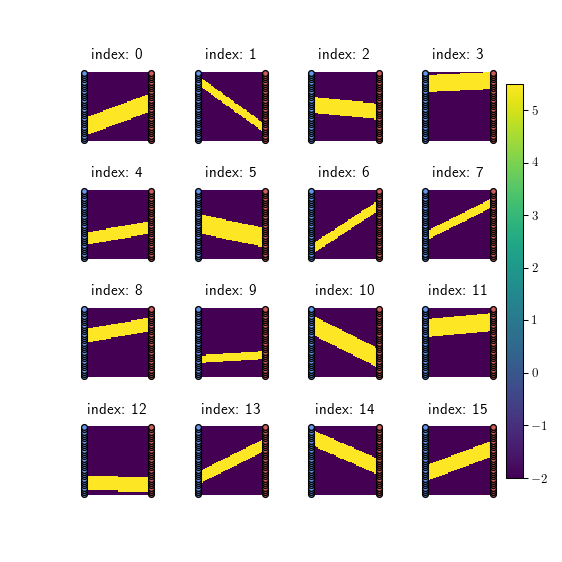

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)
k_train = np.load('../envs_params/env_data/k_log_md_train_clustered.npy')
fig = plot_k_array(k_train, env_train.q.copy(), rows=4, cols=4, marker_size=20)
fig.savefig(data_dir+'/'+case_label+'_k_train.pdf')

# plot evaluation log-permeabilities

<IPython.core.display.Javascript object>


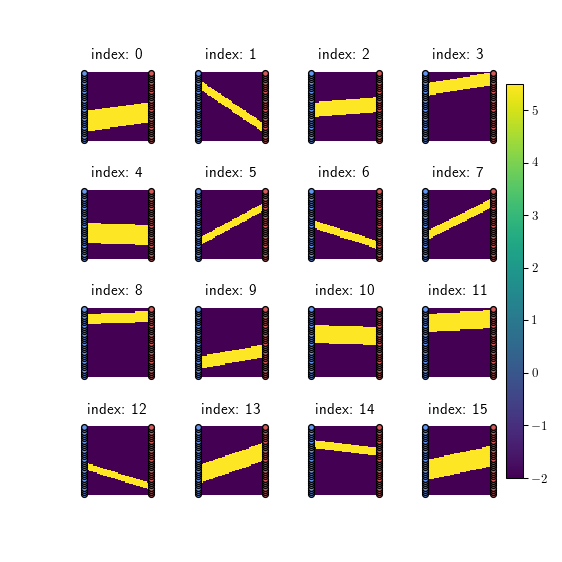

In [6]:
k_eval = np.load('../envs_params/env_data/k_log_md_eval_clustered.npy')
fig = plot_k_array(k_eval, env_train.q.copy(), rows=4, cols=4, marker_size=20)
fig.savefig(data_dir+'/'+case_label+'_k_eval.pdf')

In [7]:
# env wrapper to reduce state space
rl_k_eval_indices = list(range(16))
x_coords, y_coords = env_train.p_x, env_train.p_y
def env_wrappers(env, x_coords, y_coords):
    env = StateCoarse(env, x_coords, y_coords, include_well_pr=True)
    return env

model_sg = PPO.load(ppo_dir_sg_one+'/seed_'+str(seed)+'/best_model_train/best_model')
model_fixed_mg = PPO.load(ppo_dir_fixed_mg+'/seed_'+str(seed)+'/best_model_train/best_model')
model_ada_mg = PPO.load(ppo_dir_ada_mg+'/seed_'+str(seed)+'/best_model_train/best_model')

with open('../envs_params/env_data/env_list_eval.pkl', 'rb') as input:
    envs = pickle.load(input)

envs_coarse = []
for env in envs:
    env = env_wrappers(env, x_coords, y_coords)
    envs_coarse.append(env)
    
models=[model_sg, model_fixed_mg, model_ada_mg ]
model_names = ['single\ngrid', 'fixed\nmulti\ngrid', 'adaptive\nmulti\ngrid']
model_base_steps = 1

s_array_eval, a_array_eval, r_array_eval, case_names_eval = get_sar_data(envs_coarse, rl_k_eval_indices,
                                                                         opt_dir,
                                                                         models, model_names, model_base_steps = 0)

# plot results for evaluation permeabilities

<IPython.core.display.Javascript object>


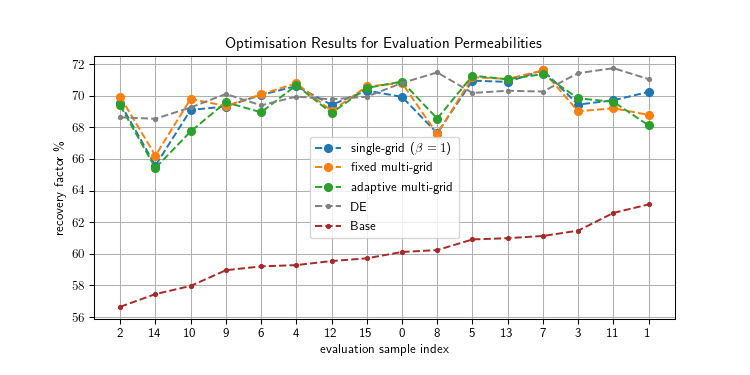

In [8]:
# plot rewards (oil recovery)
model_names = [r'single-grid ($\beta=1$)', 'fixed multi-grid', 'adaptive multi-grid']
fig, axs = plt.subplots(1,1,figsize=(8,4))
plt.subplots_adjust(left=None,bottom=0.15,right=None,top=0.85,wspace=0.1,hspace=0.1)
plot_rewards(r_array_eval, axs, model_names)
fig.savefig(data_dir+'/'+case_label+'_r_eval.pdf')

# visualize optimal policies

<IPython.core.display.Javascript object>


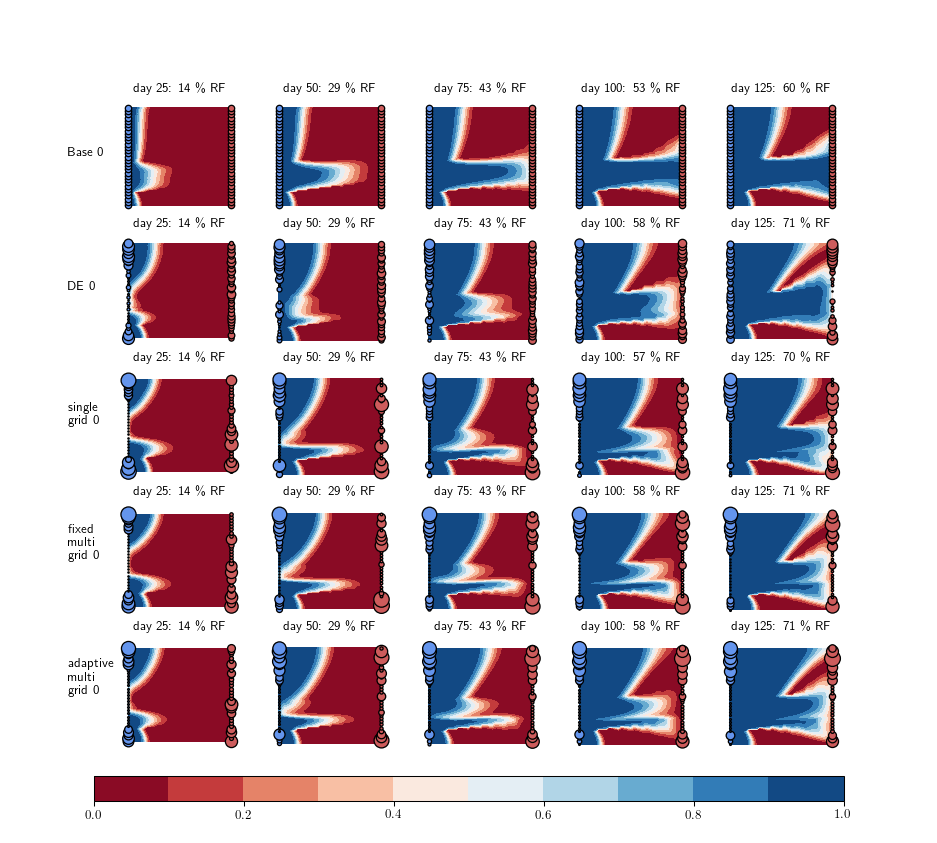

<IPython.core.display.Javascript object>


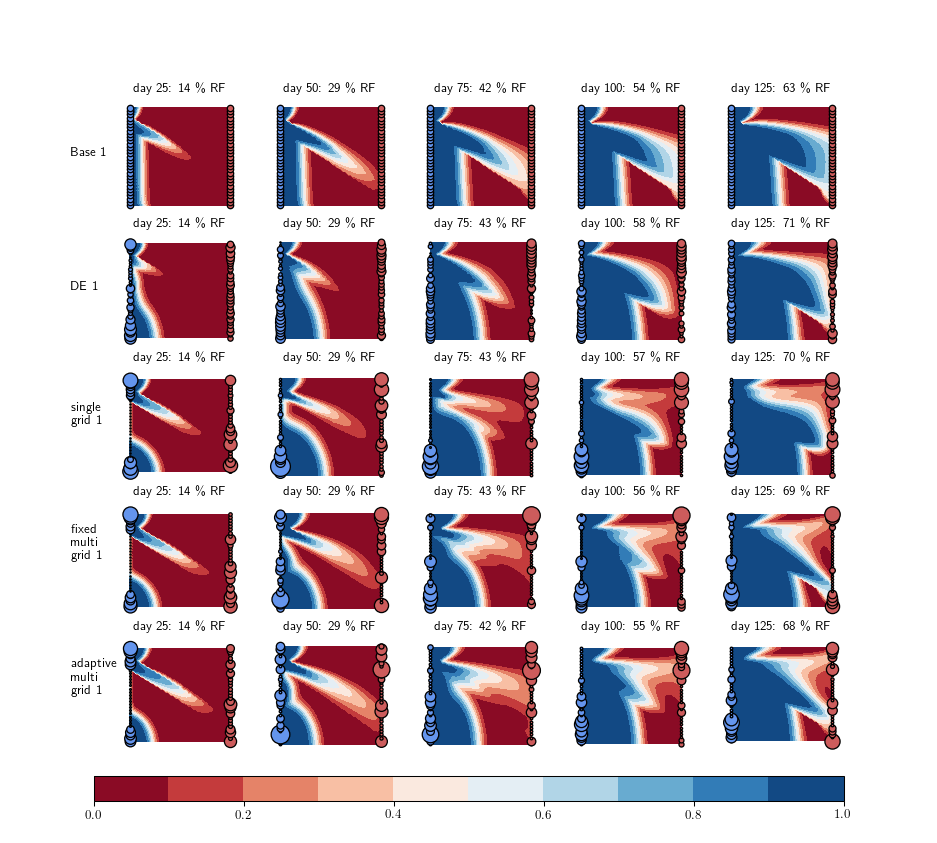

<IPython.core.display.Javascript object>


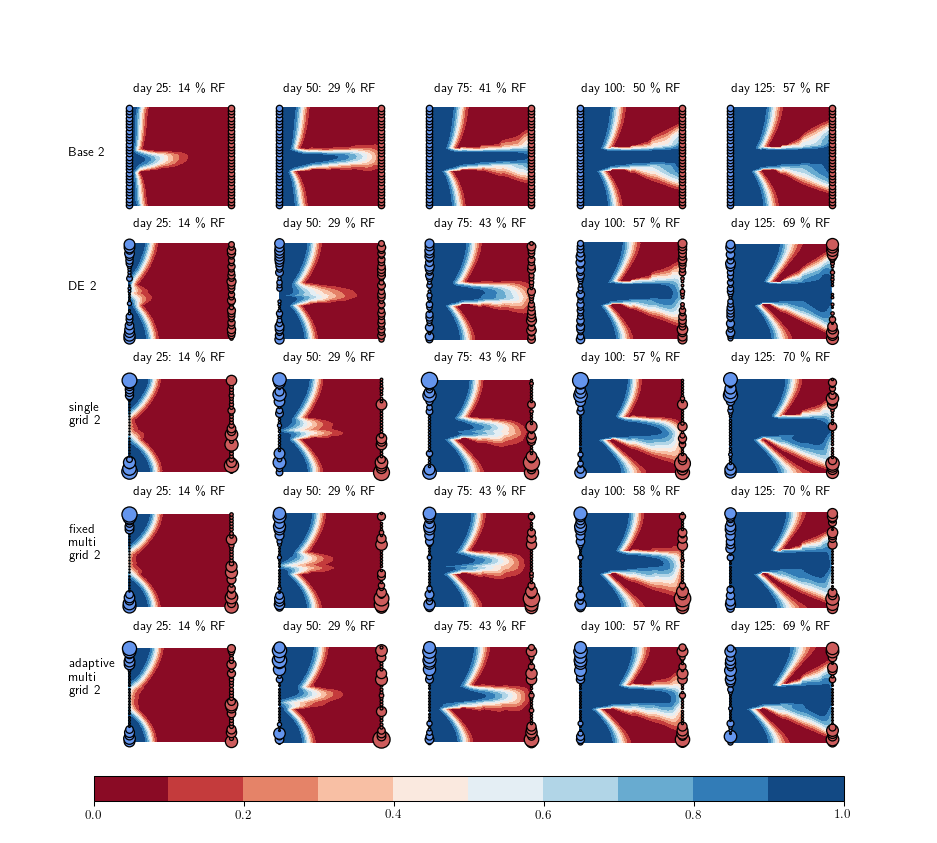

<IPython.core.display.Javascript object>


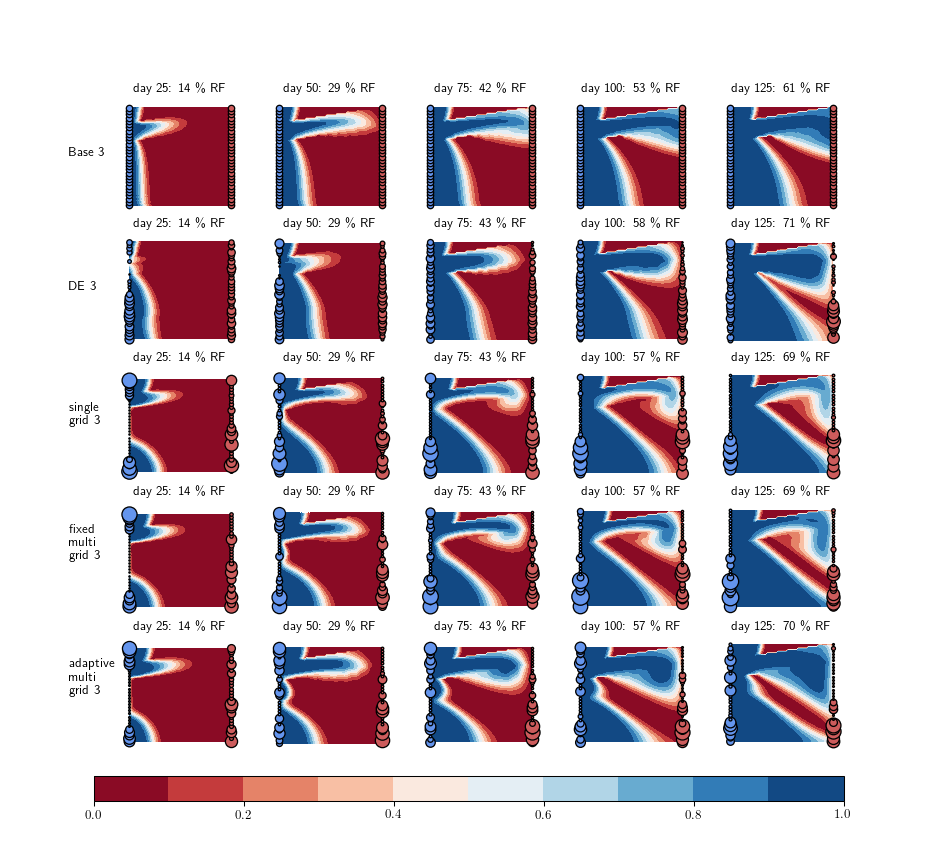

<IPython.core.display.Javascript object>


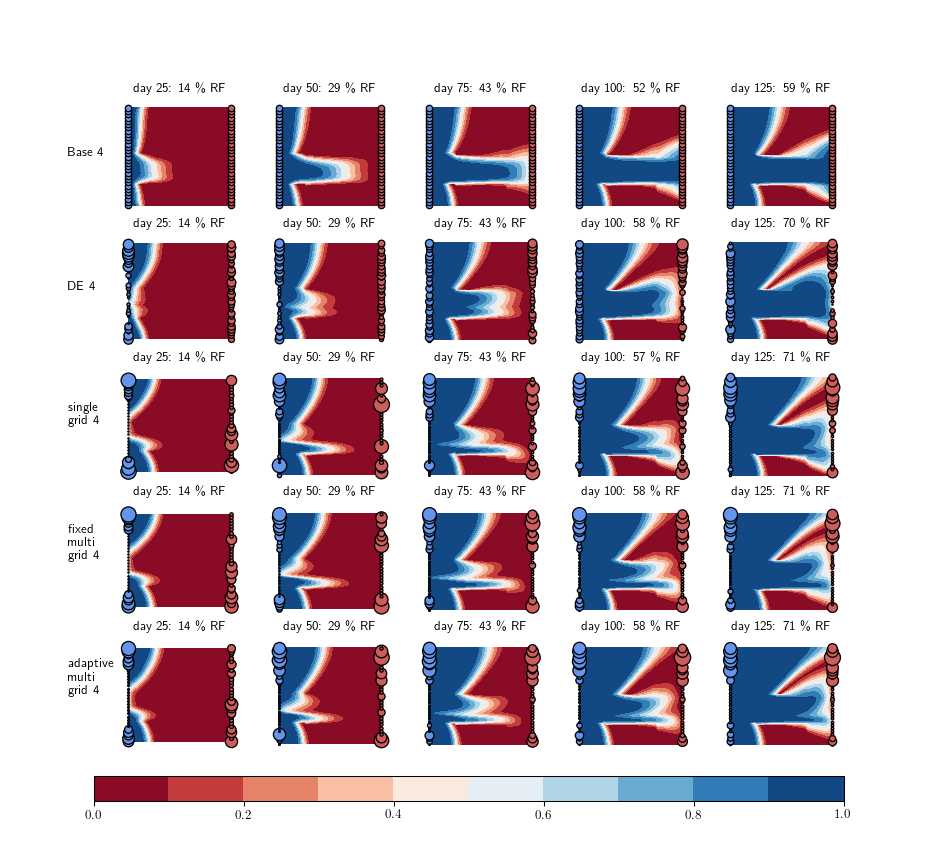

<IPython.core.display.Javascript object>


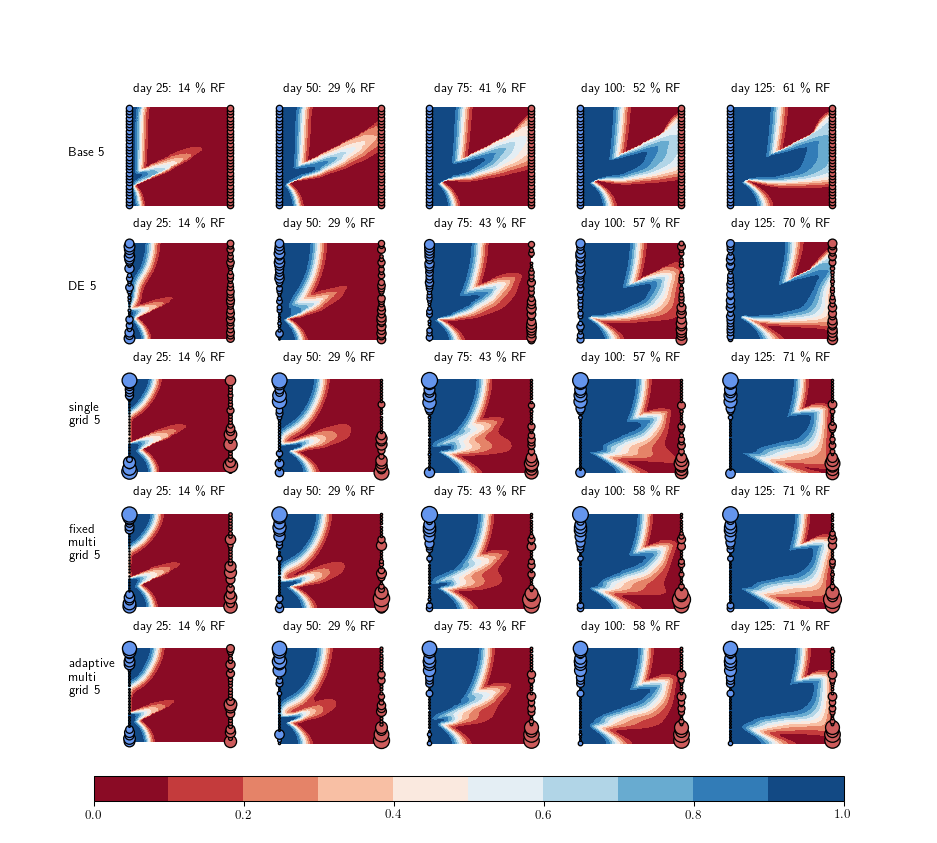

<IPython.core.display.Javascript object>


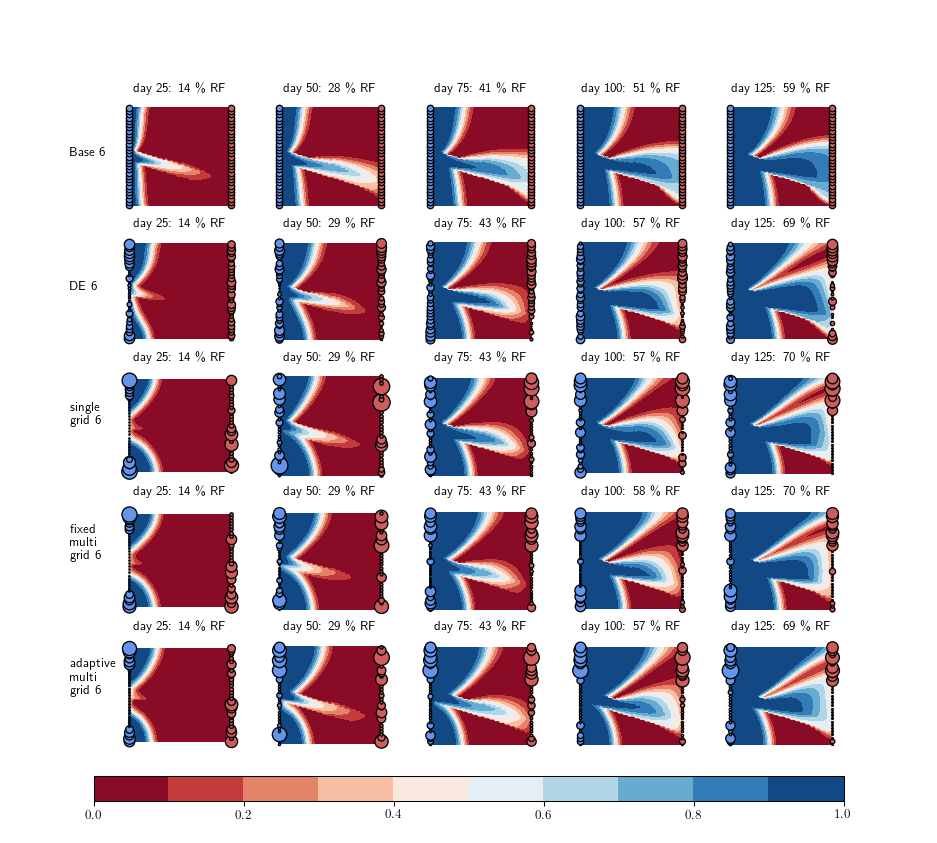

<IPython.core.display.Javascript object>


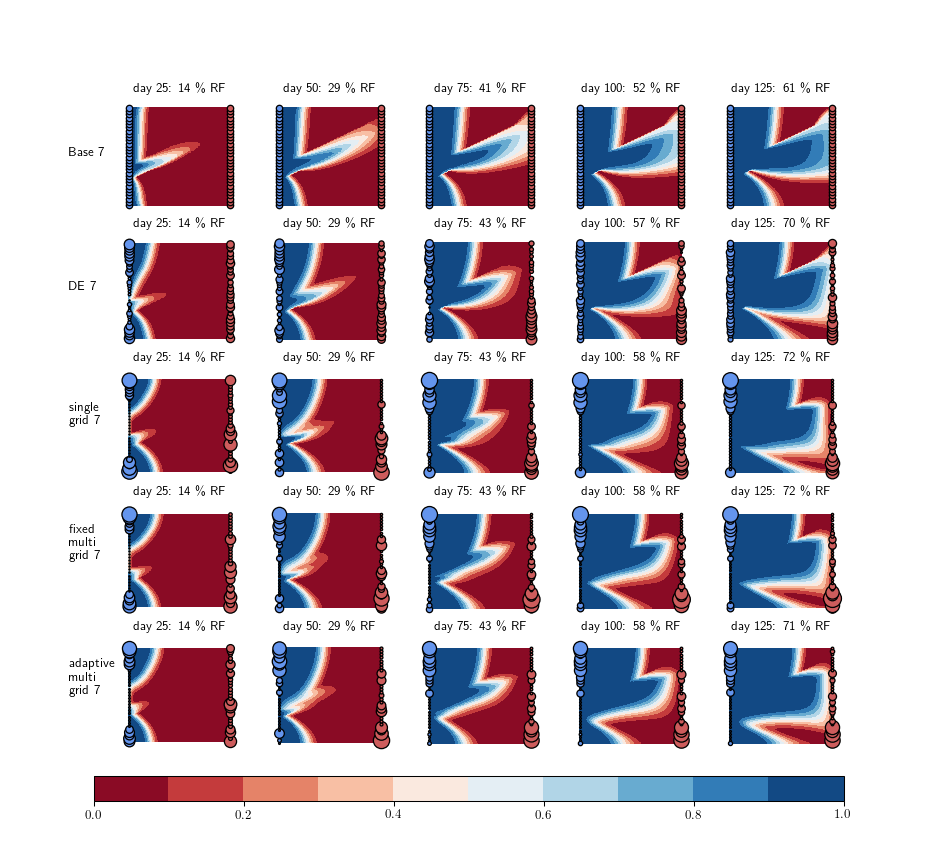

<IPython.core.display.Javascript object>


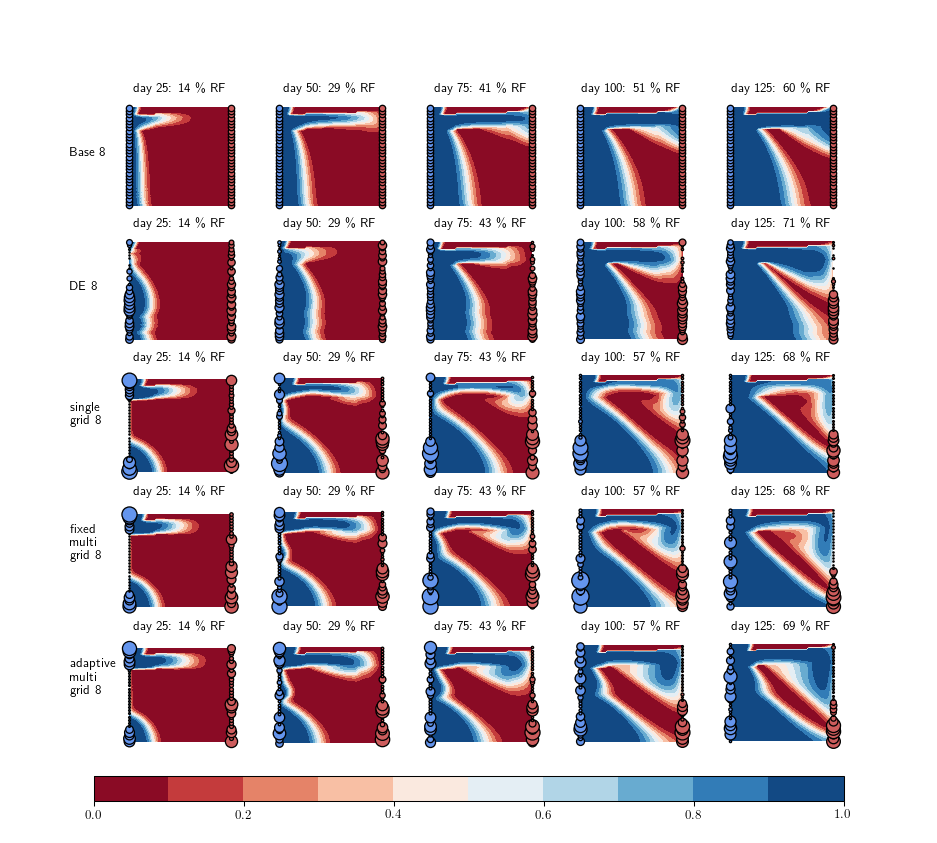

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# plot actions (well schedules)
for i,(r_array, a_array, s_array, case_names) in enumerate(zip(r_array_eval, a_array_eval, s_array_eval, case_names_eval)):
        fig = plot_actions(r_array, a_array, s_array, case_names,
                 s_min=0, s_max=1, 
                 levels=10, show_wells=True, marker_size_ref=5,
                 time_per_step=25, time_unit='day', figsize=(10,9))
        fig.savefig(data_dir+'/'+case_label+'_a_eval_'+str(i)+'.pdf')